In [1]:
## Reload the modules each time there are modified
%load_ext autoreload
%autoreload 2

In [96]:
import numpy as np
import matplotlib.pyplot as plt

from src.arms import Bernoulli
from src.stochastic_bandit import MAB, BernoulliMAB
from src.multiplayers import multiplayer_env, PlayerRandTop, PlayerMCTop, UCB1Policy, KlUCBPolicy

In [97]:
arm = Bernoulli(0.4)
arm

Bernoulli(0.4)

(0.0, 1.5)

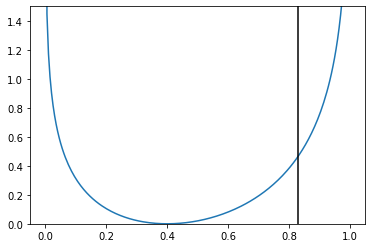

In [4]:
qq = np.linspace(0, 1, 200)
plt.plot(qq, [Bernoulli.kl(0.4, q) for q in qq])

plt.axvline(Bernoulli.kl_ucb(0.4, np.log(100) / 10), c="k")

plt.ylim([0, 1.5])

In [5]:
Bernoulli.kl_ucb(0.4, np.log(100) / 10)

0.8286230589491665

In [6]:
Bernoulli.kl_ucb(0.9, np.log(10), 1e-6)

0.9999996185302734

In [7]:
arm.kl_ucb(0.4, np.log(100)/10, 0.1)

0.8286230589491665

In [105]:
def print_loading(i, n):
    m = int((100 * i / n) // 5)
    print(f"\r{i}/{n}", "[" + "="*m + " "*(20-m) + "]",f"({100 * i / n:.0f}%)", end='')

In [106]:
MAB([Bernoulli(0.2), Bernoulli(0.3)]), BernoulliMAB([0.2, 0.3])
BernoulliMAB([0.5, 0.2, 0.8, 0.6, 0.3, 0.35, 0.7]).m_worst_arms_means(3)

array([0.5 , 0.35, 0.3 , 0.2 ])

In [163]:
bandit = BernoulliMAB([0.2, 0.3, 0.5, 0.75, 0.8])
K, M = bandit.nb_arms, 3
policy = UCB1Policy(alpha=0.5)
players = [PlayerMCTop(K, M, policy) for _ in range(M)]

In [164]:
    selections, collisions, chairs, sensing_infos = multiplayer_env(bandit, players, 20)

In [165]:
selections, collisions

(array([[2, 3, 4, 0, 1, 1, 0, 1, 1, 4, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1],
        [3, 4, 0, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1],
        [0, 3, 2, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 4, 4]]),
 array([[False,  True, False, False, False, False,  True,  True,  True,
          True,  True,  True,  True, False, False, False, False,  True,
          True,  True],
        [False, False, False,  True, False, False,  True,  True,  True,
         False,  True,  True, False, False, False, False, False, False,
          True,  True],
        [False,  True, False,  True, False, False, False, False, False,
          True, False, False,  True, False, False, False, False,  True,
         False, False]]))

In [148]:
np.cumsum((collisions & (selections == 3)).sum(0))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 4, 4, 4, 4, 6])

In [168]:
np.cumsum((selections == 0).sum(0))

array([1, 1, 2, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7, 7, 7])

20/20 [====================] (100%)

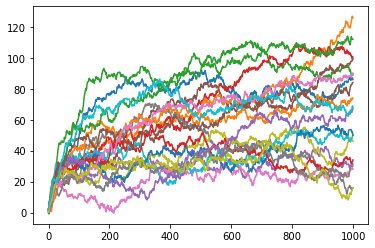

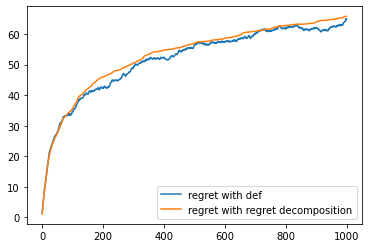

In [242]:
T = 1000
N_exp = 20
oracle_cumulative_regret = bandit.m_best_arms_means(M).sum() * np.arange(1,T+1)
average_cumulative_regret = np.zeros(T)
number_of_selections_of_arms = np.zeros((K, T))
number_of_colliding_players_on_arms = np.zeros((K, T))
end_regrets = []
end_regrets_2 = []
for i in range(N_exp):
    for player in players:
        player.clear()
    selections, collisions, chairs, sensing_infos = multiplayer_env(bandit, players, T)
    rewards = sensing_infos * (~ collisions)

    cumulative_pseudo_regret = oracle_cumulative_regret - np.cumsum(rewards.sum(axis=0)) # change to empirical reward -> mu
    average_cumulative_regret += cumulative_pseudo_regret
    if T%10 == 0: plt.plot(cumulative_pseudo_regret)
    end_regrets.append(cumulative_pseudo_regret[-1])

    # regret decomposition
    for k in range(K):
        number_of_selections_of_arms[k] += np.cumsum((selections == k).sum(0))
        number_of_colliding_players_on_arms[k] += np.cumsum((collisions & (selections == k)).sum(0))

    print_loading(i+1, N_exp)
average_cumulative_regret /= N_exp
number_of_selections_of_arms /= N_exp
number_of_colliding_players_on_arms /= N_exp
plt.figure()
plt.plot(average_cumulative_regret)

cum_c = (bandit.means[:, np.newaxis] * number_of_colliding_players_on_arms).sum(0)
gaps = bandit.means - bandit.last_best_arm_mean(M)

plt.plot(np.where(gaps[:, np.newaxis] < 0,  - gaps[:,np.newaxis] * number_of_selections_of_arms, gaps[:,np.newaxis] * (np.arange(1,T+1) - number_of_selections_of_arms)).sum(0) + cum_c)
plt.legend(["regret with def", "regret with regret decomposition"])


In [187]:
c = (bandit.means * number_of_colliding_players_on_arms[:,-1]).sum()
c

22.80525

In [186]:
cum_c = (bandit.means[:, np.newaxis] * number_of_colliding_players_on_arms).sum(0)

In [188]:
mu_m_star = bandit.last_best_arm_mean(M)
mu_m_star

0.5

In [192]:
gaps = bandit.means - mu_m_star
gaps, number_of_selections_of_arms[:,-1]

(array([-0.3 , -0.2 ,  0.  ,  0.25,  0.3 ]),
 array([ 45.915,  76.965, 919.56 , 976.825, 980.735]))

In [198]:
for k in range(K):
    if gaps[k] < 0:
        print(k, -gaps[k] * number_of_selections_of_arms[k,-1])
    else:
        print(k, gaps[k] * (T - number_of_selections_of_arms[k,-1]))

0 13.7745
1 15.393
2 0.0
3 5.793749999999989
4 5.779499999999997


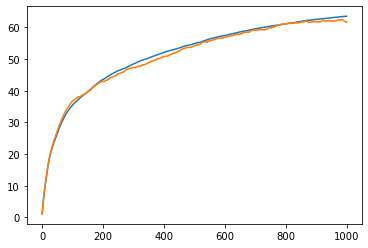

In [238]:
plt.plot(np.where(gaps[:, np.newaxis] < 0,  - gaps[:,np.newaxis] * number_of_selections_of_arms, gaps[:,np.newaxis] * (np.arange(1,T+1) - number_of_selections_of_arms)).sum(0) + cum_c)
plt.plot(average_cumulative_regret)

In [ ]:
bandit.

(array([  1.,   2.,  13.,  14.,  37.,  70.,  92., 134., 160., 142.,  98.,
         82.,  66.,  41.,  28.,  13.,   3.,   1.,   2.,   1.]),
 array([-26.  , -16.05,  -6.1 ,   3.85,  13.8 ,  23.75,  33.7 ,  43.65,
         53.6 ,  63.55,  73.5 ,  83.45,  93.4 , 103.35, 113.3 , 123.25,
        133.2 , 143.15, 153.1 , 163.05, 173.  ]),
 <a list of 20 Patch objects>)

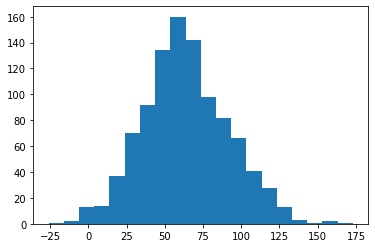

In [91]:
plt.hist(end_regrets, bins=20)

In [79]:
rewards = sensing_infos * (~ collisions)
rewards

array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

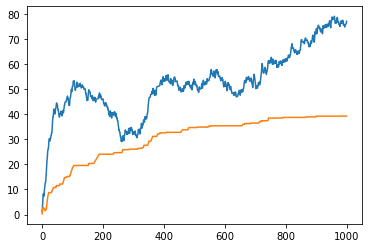

In [81]:
plt.plot(bandit.best_arms_means(M).sum() * np.arange(1,T+1) - np.cumsum(rewards.sum(0)))
plt.plot(cumulative_centralised_regret(bandit, selections))

In [41]:
rewards.sum()

43.0

In [56]:
bandit.best_arms_means(M).sum() * np.arange(1,44+1)

array([ 2.05,  4.1 ,  6.15,  8.2 , 10.25, 12.3 , 14.35, 16.4 , 18.45,
       20.5 , 22.55, 24.6 , 26.65, 28.7 , 30.75, 32.8 , 34.85, 36.9 ,
       38.95, 41.  , 43.05, 45.1 , 47.15, 49.2 , 51.25, 53.3 , 55.35,
       57.4 , 59.45, 61.5 , 63.55, 65.6 , 67.65, 69.7 , 71.75, 73.8 ,
       75.85, 77.9 , 79.95, 82.  , 84.05, 86.1 , 88.15, 90.2 ])

In [43]:
for i in cumulative_centralised_regret(bandit, selections):
    print(i)

0.44999999999999996
0.44999999999999996
1.25
2.0
2.6000000000000005
2.6
2.9000000000000004
3.05
3.0
3.2500000000000004
3.3999999999999995
3.6500000000000004
3.6000000000000005
3.8499999999999996
3.8500000000000005
3.8499999999999996
4.65
5.549999999999999
5.3
5.050000000000001
4.8
4.549999999999999
4.3
4.050000000000001
4.05
4.35
4.1000000000000005
3.8499999999999996
3.5999999999999988
3.3499999999999996
3.1000000000000005
2.8499999999999996
2.5999999999999988
2.3499999999999996
2.1000000000000005
1.8499999999999996
1.5999999999999979
1.3499999999999979
1.0999999999999979
0.8499999999999961
0.5999999999999943
0.2999999999999936
-7.105427357601002e-15
-0.3000000000000078


In [11]:
j = 1
L = [0] * K
for i in range(len(selections[0])):
    L[selections[j,i]] += sensing_infos[j,i]
L

[0.0, 0.0, 3.0, 7.0, 22.0]

In [12]:
players[j].cum_rewards

array([ 0.,  0.,  3.,  7., 22.])

In [10]:
banditA = BernoulliMAB([0.45, 0.5, 0.6])
banditB = BernoulliMAB([0.1, 0.05, 0.02, 0.01])

K, M = banditA.nb_arms, 1
kl_ucb_policy = KlUCBPolicy(arms_types=banditA.arms)
players = [PlayerMCTop(K, M, kl_ucb_policy) for _ in range(M)]

selections, collisions, chair , sensing_infos = multiplayer_env(banditA, players, 100)

In [11]:
rewards = sensing_infos * (~ collisions)

In [15]:
 L = [1, 2, 4, 5, 6, 7, 8, 9]
 c = np.array([False, False, False, True, False, True, True, False])
 np.where(~c, L, 0), ~c * L

(array([1, 2, 4, 0, 6, 0, 0, 9]), array([1, 2, 4, 0, 6, 0, 0, 9]))